# Ciągła ocena modelu za pomocą BigQuery ML, procedur składowanych i Cloud Scheduler (Blog)

* https://cloud.google.com/blog/topics/developers-practitioners/continuous-model-evaluation-bigquery-ml-stored-procedures-and-cloud-scheduler

##Architektura

* BigQuery ML
* Cloud Scheduler
* Cloud Functions

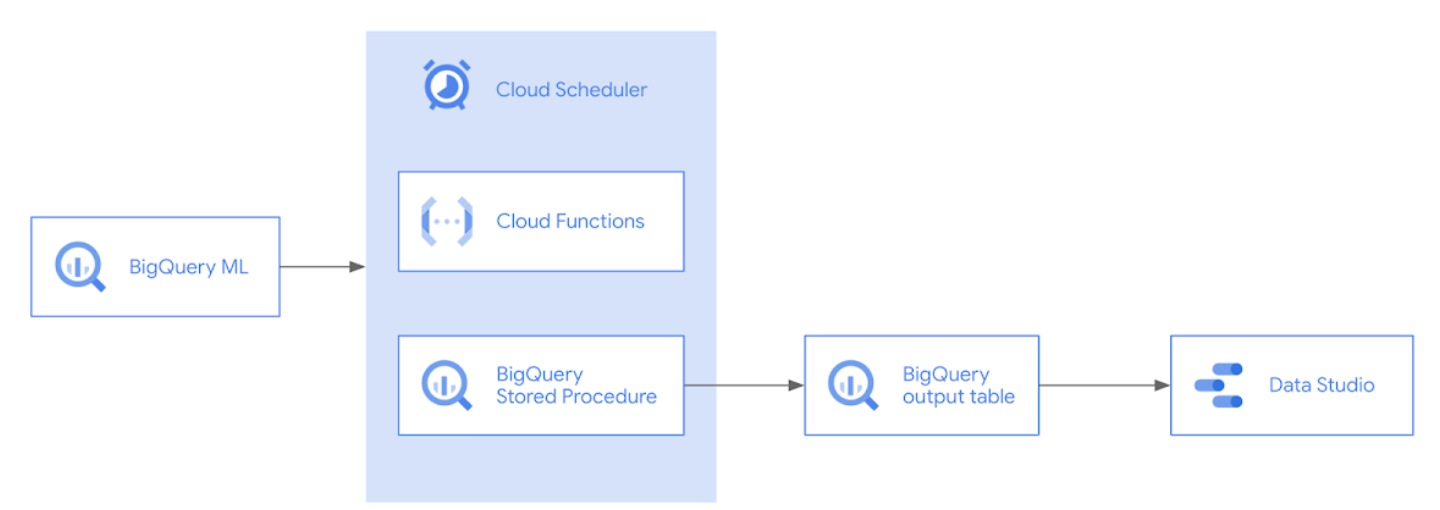

###1. Tworzenie modelu za pomocą BigQuery ML

####CREATE OR REPLACE MODE

In [ ]:
%%bigquery

CREATE OR REPLACE MODEL models.linreg
OPTIONS( model_type="linear_reg",
  input_label_cols=["ArrDelay"] ) AS
SELECT
  *
FROM
  flights.train

###2. Prognozowanie na podstawie modelu

####ML.PREDICT

###3. Ocena danych

####ML.EVALUATE

* Możemy monitorować skuteczność naszych modeli uczenia maszynowego na przestrzeni czasu w oparciu o nowe dane, regularnie oceniając nasze modele i umieszczając je w tabeli w BigQuery

In [ ]:
%%bigquery

SELECT
  *
FROM
  ML.EVALUATE(MODEL models.linreg,
    (SELECT * FROM flights.test))

* Oprócz tych metryk będziemy również chcieli przechowywać pewne metadane, takie jak nazwa ocenianego przez nas modelu i sygnatura czasowa oceny modelu.
* Ale jak widać poniżej, utrzymanie poniższego kodu może szybko stać się trudne, ponieważ za każdym razem, gdy wykonasz zapytanie, będziesz musiał dwukrotnie ( `MY_MODEL_NAME` w liniach 3 i 6) zastąpić nazwę utworzonego modelu (np. `„linreg”`).

In [ ]:
%%bigquery

SELECT
 CURRENT_TIME() AS timestamp,
 "MY_MODEL_NAME" AS modelname, # linia 3
 *
 FROM
 ML.EVALUATE(MODEL models.MY_MODEL_NAME, # linia 6
   (SELECT * FROM flights.test)
    )

### 4. Tworzenie procedury składowanej do oceny przychodzących danych

https://cloud.google.com/bigquery/docs/reference/standard-sql/procedural-language#beginexception

https://cloud.google.com/bigquery/docs/multi-statement-queries

https://cloud.google.com/bigquery/docs/procedures

* Możesz użyć procedury składowanej, która pozwala zapisywać zapytania SQL i uruchamiać je, przekazując niestandardowe argumenty, takie jak ciąg znaków określający nazwę modelu.

* Aby utworzyć procedurę składowaną, możesz wykonać następujący kod, który możesz następnie wywołać, korzystając z kodu `CALL`

```
CALL modelevaluation.evaluate("linreg");
```



In [ ]:
%%bigquery

CREATE OR REPLACE PROCEDURE modelevaluation.evaluate(MODELNAME string)
  BEGIN
  EXECUTE IMMEDIATE format("""
  SELECT
    CURRENT_TIME() as timestamp,
    "%s" AS modelname,
    *
  FROM
    ML.EVALUATE(MODEL models.%s,
      (SELECT * FROM flights.test)
    )
  """, MODELNAME, MODELNAME);

  END;

###5. Używanie procedury składowanej do wstawiania metryk oceny do tabeli

* Korzystając z poniższej procedury składowanej, możemy teraz w jednym kroku ocenić model i wstawić go do tabeli, `modelevaluation.metric` sktórą najpierw będziemy musieli utworzyć. Ta tabela musi być zgodna z tym samym schematem, co w procedurze składowanej. Być może najłatwiejszym sposobem jest użycie LIMIT 0, które jest bezpłatnym zapytaniem zwracającym zero wierszy, przy zachowaniu schematu.

In [ ]:
%%bigquery

CREATE OR REPLACE TABLE modelevaluation.metrics AS (
  SELECT
    CURRENT_TIME() as timestamp,
      "linreg" AS modelname,
      *

    FROM
      ML.EVALUATE(MODEL models.linreg,
        (SELECT * FROM flights.test)
      )
  LIMIT 0
)

* Po utworzeniu tabeli za każdym razem, gdy uruchomisz procedurę składowaną na swoim modelu „linreg”, oceni on model i wstawi go jako nowy wiersz do tabeli:

In [ ]:
CALL modelevaluation.evaluate_and_insert("linreg");

###6. Ciągła ocena za pomocą Cloud Functions i Cloud Scheduler

* Aby uruchamiać procedurę składowaną cyklicznie, możesz utworzyć Cloud Functions z kodem, który chcesz uruchomić, i uruchomić Cloud Functions za pomocą harmonogramu zadań cron, takiego jak Cloud Scheduler.

* Wchodząc na stronę Cloud Functions w GCP, utwórz nową funkcję Cloud Function, która korzysta z typu wyzwalacza HTTP.

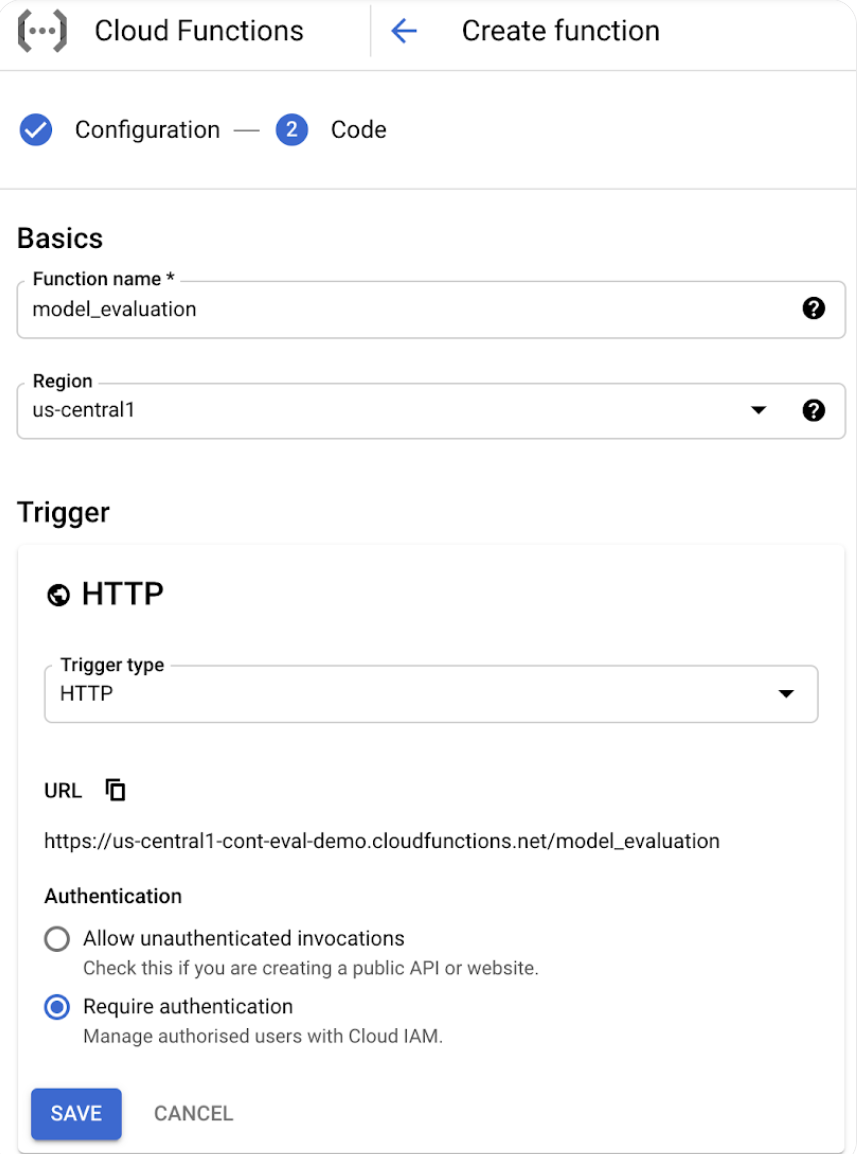

* Zanotuj adres URL, który będzie adresem URL wyzwalającym tę Funkcję Cloud. Powinno to wyglądać mniej więcej tak:

```
https://<region>-<projectid>.cloudfunctions.net/<functionname>
```

* Kliknięcie „Dalej” w Cloud Functions przeniesie Cię do edytora, w którym możesz wkleić następujący kod, ustawiając środowisko wykonawcze na „Python” i zmieniając „Punkt wejścia” na `„updated_table_metrics”`:

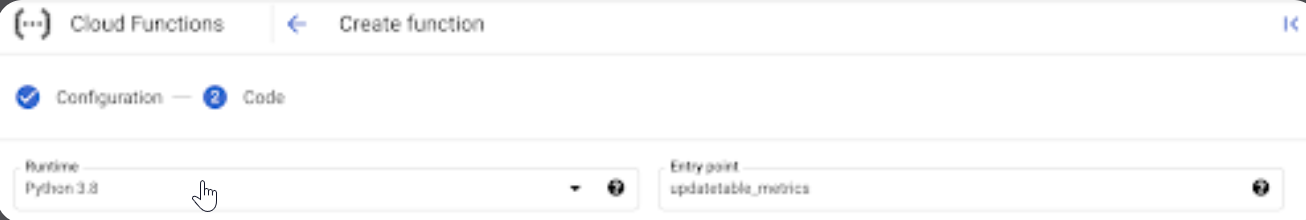

* W obszarze `main.py` możesz użyć następującego kodu

In [ ]:
from google.cloud import bigquery
from google.api_core.exceptions import BadRequest
import time

# Construct a BigQuery client object.
client = bigquery.Client()

def bq_query(sql, async_flag=False):
    """
    Submits a SQL query to BigQuery.
    """

    # Try dry run before executing query to catch any errors
    try:
        print("Trying test run")
        job_config = bigquery.QueryJobConfig(dry_run=True, use_query_cache=False)
        dry_run_job = client.query(sql, job_config=job_config)
    except BadRequest as err:
        print("Error occurred on test run:")
        print(err)
        return

    job_config = bigquery.QueryJobConfig()
    client.query(sql, job_config=job_config)
    return

def updatetable_metrics(request):
    """
    Calls BQ stored procedure to evaluate and add evaluation metrics
    to table: modelevaluation.metrics
    """

    MODELNAME = "linreg"
    sql = f"""
        CALL `MY-PROJECT-ID`.modelevaluation.evaluate_and_insert("{MODELNAME}")
        """
    bq_query(sql)
    print(f"Called: '{sql}'")

    return "Function ran successfully"

* Poniżej `requirements.txt`, możesz wkleić następujący kod dla wymaganych pakietów

In [ ]:
google-cloud-bigquery
google-api-core

* Następnie, aby regularnie uruchamiać Funkcję Cloud, utworzymy nowe zadanie Cloud Scheduler na Google Cloud Platform.

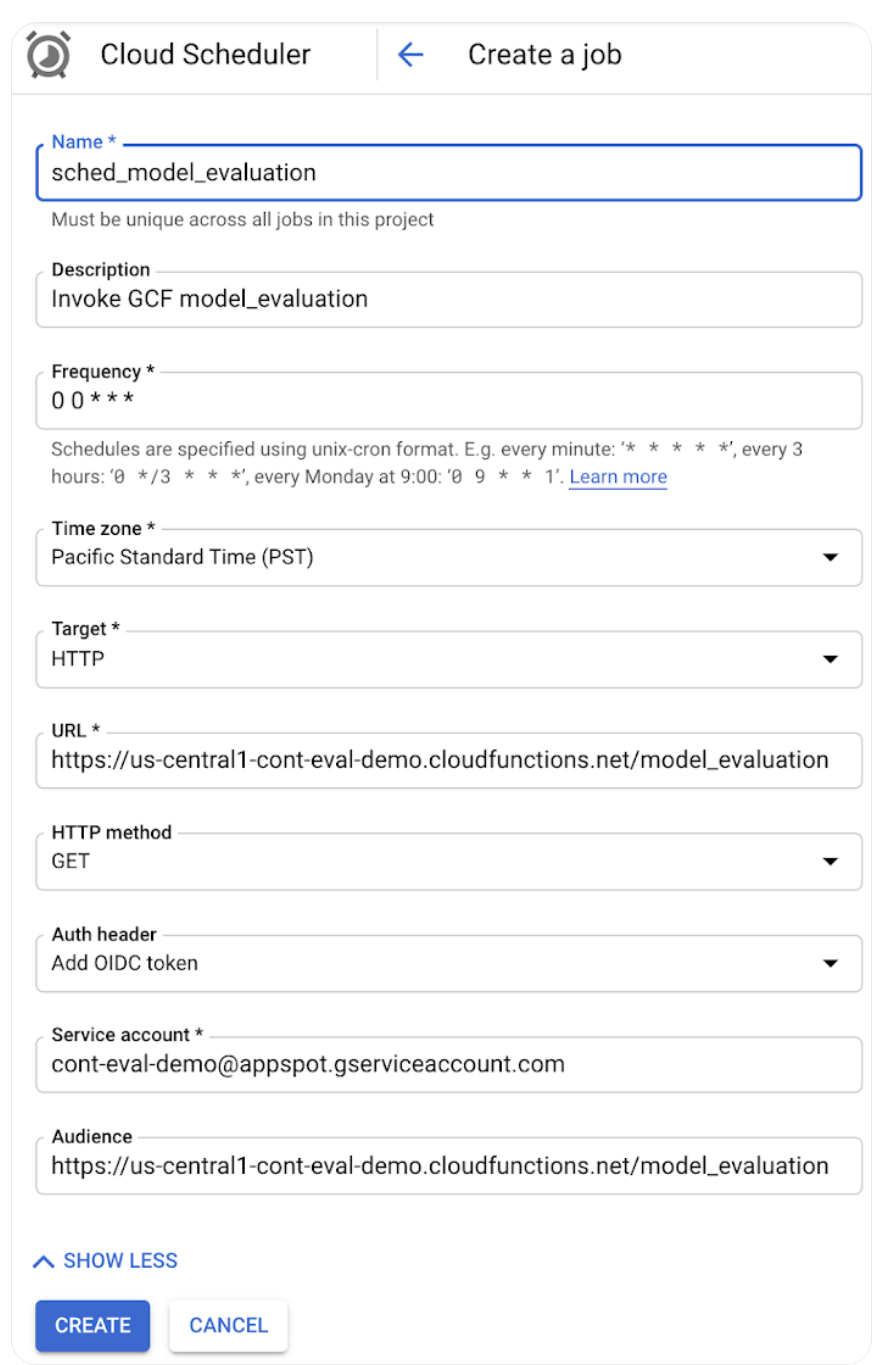

* Domyślnie Cloud Functions z wyzwalaczami HTTP będą wymagać uwierzytelnienia, ponieważ prawdopodobnie nie chcesz, aby ktokolwiek mógł uruchamiać Twoje Cloud Functions. Oznacza to, że do zadania Harmonogramu będziesz musiał dołączyć konto usługi, które ma uprawnienia IAM do:

  - Cloud Functions Invoker
  - Cloud Scheduler Service Agent

In [ ]:
%%bigquery

SELECT
  timestamp,
  modelname,
  SQRT(mean_squared_error) as rmse
FROM
  evaluation.metrics

###Wizualizacja metryk naszego modelu

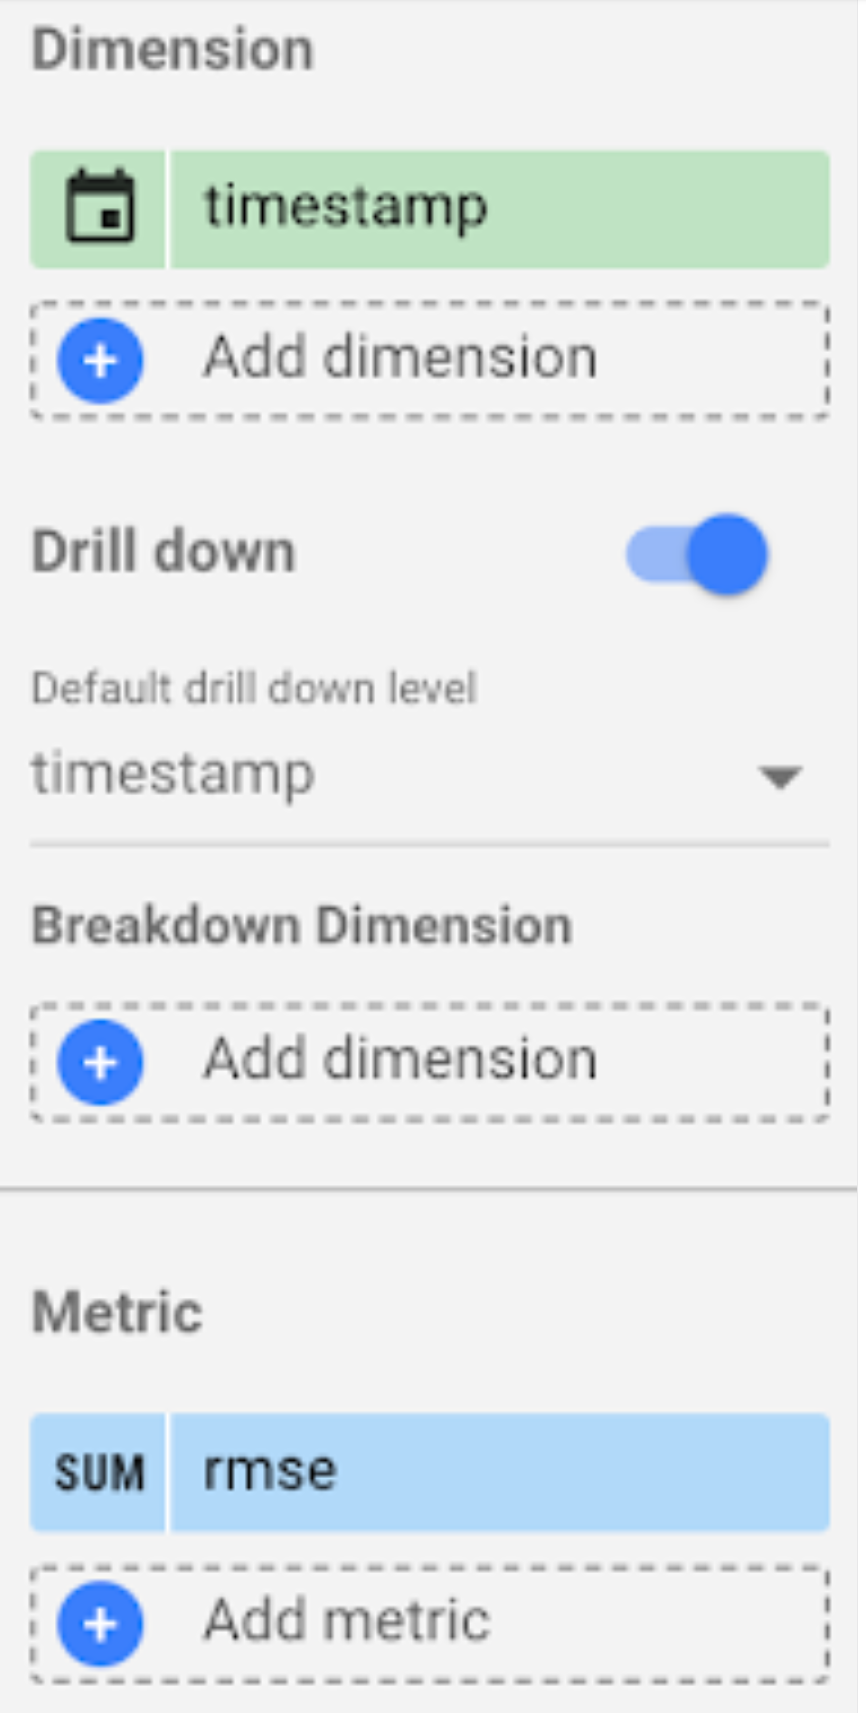

# Scheduling and automating model retaining with scheduled queries (YT)

* https://storage.googleapis.com/spls/gsp852/gsp852-clip3.mp4

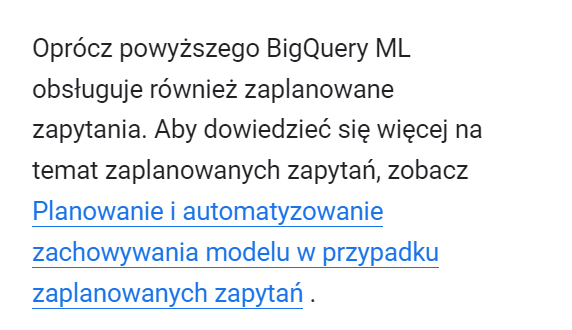

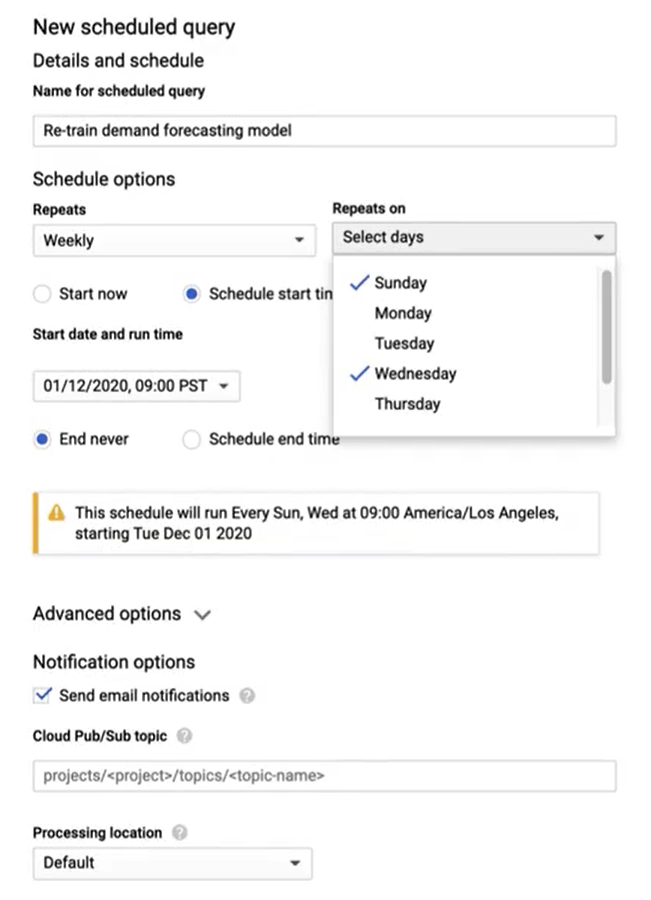

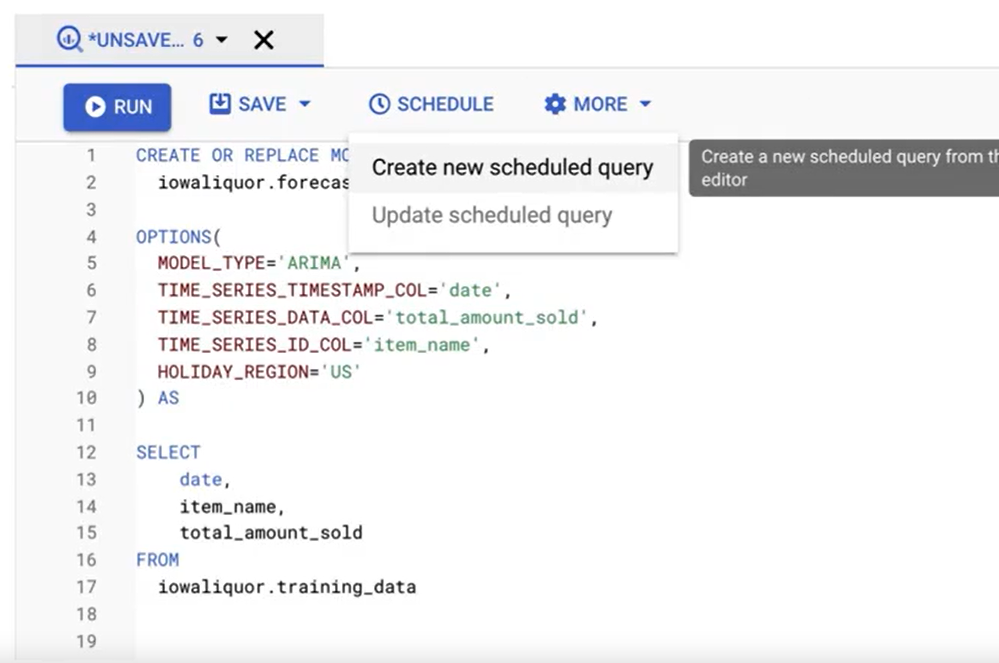



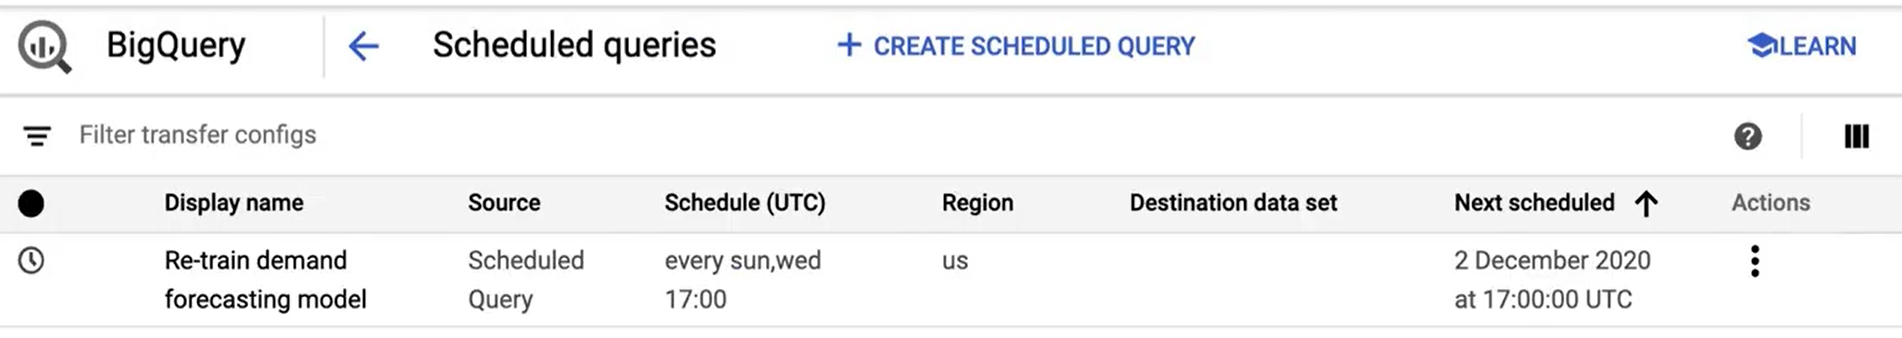